# COVID-19 mRNA Vaccine Degradation Prediction

mRNA vaccines were the fastest vaccine candidates for COVID-19. However, they face a massive problem which is how to design a super stable messenger RNA molecules (mRNA). Conventional vaccines don't have this problem because they can just be stored in syringes, refigerated, and shipped like that. Researches have noticed that RNA molecules seem to degrade almost spotaneously. A single bad cut can render the mRNA vaccine useless. The goal of this project design and implement a machine learning model that can predict whether a RNA molecule will degrade or not.

## Import relevant libraries

In [1]:
import json
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers

## Load training and test set

The training and test set comes in JSONs so we can use pandas to read in the data. We'll read in the sample submission to see how the submitted file is supposed to be formatted

In [2]:
path = '../data/'

train = pd.read_json(path + 'train.json', lines=True)
test = pd.read_json(path + 'test.json', lines=True)

train.to_csv(path + 'train.csv')
test.to_csv(path + 'test.csv')

## Visualise test and training data

Let's have a look at how the training and test data look

In [3]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [4]:
test.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [5]:
train['seq_length'].value_counts()

107    2400
Name: seq_length, dtype: int64

## Define target columns

We need to define which columns are going to be our target variables

In [6]:
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

## Loss function

We'll be using MCRMSE (Mean column-wise root mean squared error). It takes the squared error for each column, roots all the columns and finally takes the mean of these roots. Here's the formula:

<img align="left" width="500" height="500" src="https://miro.medium.com/max/720/0*xtGq9Gtp5ZGfO2tm.png">


In [7]:
def MCRMSE(y_true, y_pred):
    diff = tf.subtract(y_true, y_pred)
    colwise_mse = tf.math.reduce_mean(tf.square(diff), axis=1)
    return tf.math.reduce_mean(tf.sqrt(colwise_mse), axis=1)

## Split test set into public and private

The test set will be split into a public and private. It will be split by sequence length where the public set will have a length of 107 (the same as the training set) and the private will have a length of 130.

In [8]:
public_df = test.query("seq_length == 107")
private_df = test.query("seq_length == 130")

## Filtering training data

To ensure that the test set is diverse and of high quality, Kaggle has only included data that has a signal to noise ratio of above 1. We will also filter our training data in the same way to ensure the test and training data come from the same distribution

We will also define a token 2 integer dictionary to make data transformation easier in the next step

In [9]:
train = train.query("signal_to_noise >= 1")

token2int = {x: i for i, x in enumerate('().ACGUBEHIMSX')}
token2int

{'(': 0,
 ')': 1,
 '.': 2,
 'A': 3,
 'C': 4,
 'G': 5,
 'U': 6,
 'B': 7,
 'E': 8,
 'H': 9,
 'I': 10,
 'M': 11,
 'S': 12,
 'X': 13}

## Data transformation

We will be transforming the data using 2 methods:

- `dataframe_to_array` which takes in a pandas dataframe converts it to a numpy array and transposes the last 2 columns so that it can be in the form of sequence data. This will be used for the input data

- `dataframe_label_encoding` takes in the sequence, structure, and predicted_loop of a dataframe and encodes the the string using the `token2int` dictionary we defined earlier

In [10]:
def dataframe_to_array(df):
    return np.transpose(np.array(df.values.tolist()), (0, 2, 1))

def dataframe_label_encoding(df, token2int, cols=['sequence', 'structure', 'predicted_loop_type']):
    return dataframe_to_array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]))

### Apply transforms to the training set

In [11]:
train_inputs = dataframe_label_encoding(train, token2int)
train_labels = dataframe_to_array(train[target_cols])

In [12]:
x_train, x_val, y_train, y_val = train_test_split(train_inputs, train_labels, test_size=0.1, stratify=train.SN_filter)

### Apply transforms to public and private test

In [13]:
public_inputs = dataframe_label_encoding(public_df, token2int)
private_inputs = dataframe_label_encoding(private_df, token2int)

## Building the Model


Now that all the training and test data are in place, we can define our model architecture. We will be putting this in a function that returns our model. We will be doing this since we'll need to build 3 models due to the different combinations of prediction and sequence lengths

### Model Architecture

For this project, we will be testing different RNN layers such as simple RNNs, LSTMS and GRUs. We will take the best performing layer and train it to predict our test set.

In [14]:
def build_model(arch, seq_len=107, pred_len=68):
    embed_size = 14
    embed_dim = 200
    
    inputs = layers.Input(shape=(seq_len, 3))
    embed = layers.Embedding(input_dim=embed_size, output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(embed, (-1, embed.shape[1], embed.shape[2] * embed.shape[3]))
    
    x = layers.SpatialDropout1D(0.2)(reshaped)
    
    
    if arch == 'gru':
        x = layers.Bidirectional(layers.GRU(256, dropout=0.5, return_sequences=True))(x)
        x = layers.Bidirectional(layers.GRU(256, dropout=0.5, return_sequences=True))(x)
        x = layers.Bidirectional(layers.GRU(256, dropout=0.5, return_sequences=True))(x)
    elif arch == 'lstm':
        x = layers.Bidirectional(layers.LSTM(256, dropout=0.5, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(256, dropout=0.5, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(256, dropout=0.5, return_sequences=True))(x)
    elif arch == 'gru':
        x = layers.Bidirectional(layers.SimpleRNN(256, dropout=0.5, return_sequences=True))(x)
        x = layers.Bidirectional(layers.SimpleRNN(256, dropout=0.5, return_sequences=True))(x)
        x = layers.Bidirectional(layers.SimpleRNN(256, dropout=0.5, return_sequences=True))(x)
    
    x_trunc = x[:, :pred_len]
    outputs = layers.Dense(5, activation='linear')(x_trunc)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='Adam', loss=MCRMSE)
    
    return model

In [15]:
model_names = ['gru', 'rnn', 'lstm']

for model_name in model_names:
    model = build_model(model_name)
    print('-- ' + model_name)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=3)

-- gru
Epoch 1/3
30/30 [==============================] - 15s 152ms/step - loss: 0.4442 - val_loss: 0.4002
Epoch 2/3
30/30 [==============================] - 3s 84ms/step - loss: 0.3838 - val_loss: 0.3785
Epoch 3/3
30/30 [==============================] - 2s 80ms/step - loss: 0.3633 - val_loss: 0.3492
-- rnn
Epoch 1/3
30/30 [==============================] - 1s 8ms/step - loss: 0.5146 - val_loss: 0.4547
Epoch 2/3
30/30 [==============================] - 0s 4ms/step - loss: 0.4459 - val_loss: 0.4474
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.4424 - val_loss: 0.4472
-- lstm
Epoch 1/3
30/30 [==============================] - 12s 155ms/step - loss: 0.5091 - val_loss: 0.4262
Epoch 2/3
30/30 [==============================] - 3s 92ms/step - loss: 0.4025 - val_loss: 0.3949
Epoch 3/3
30/30 [==============================] - 3s 89ms/step - loss: 0.3824 - val_loss: 0.3726


It seems like the GRU layer has the best performance so we'll train this for longer and use this as our model

## Build Final Model

Let's build the final model and set up a callback to save our best models weights

In [16]:
model = build_model('gru')

checkpoint_path = 'model/cp-{epoch:04d}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_path,
                    verbose=1,
                    save_weights_only=True,
                    save_best_only=True)

## Training the model

We'll train the model over 40 epochs and input the validation set so that we can keep track of the validation loss while training

In [17]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    batch_size=64, epochs=40, callbacks=[cp_callback])

Epoch 1/40
30/30 [==============================] - ETA: 0s - loss: 0.4516
Epoch 1: val_loss improved from inf to 0.39501, saving model to model\cp-0001.h5
30/30 [==============================] - 12s 127ms/step - loss: 0.4516 - val_loss: 0.3950
Epoch 2/40
30/30 [==============================] - ETA: 0s - loss: 0.3842
Epoch 2: val_loss improved from 0.39501 to 0.36995, saving model to model\cp-0002.h5
30/30 [==============================] - 2s 77ms/step - loss: 0.3842 - val_loss: 0.3699
Epoch 3/40
30/30 [==============================] - ETA: 0s - loss: 0.3621
Epoch 3: val_loss improved from 0.36995 to 0.36629, saving model to model\cp-0003.h5
30/30 [==============================] - 2s 77ms/step - loss: 0.3621 - val_loss: 0.3663
Epoch 4/40
30/30 [==============================] - ETA: 0s - loss: 0.3517
Epoch 4: val_loss improved from 0.36629 to 0.33914, saving model to model\cp-0004.h5
30/30 [==============================] - 2s 77ms/step - loss: 0.3517 - val_loss: 0.3391
Epoch 5/40

30/30 [==============================] - 2s 82ms/step - loss: 0.2188 - val_loss: 0.2282
Epoch 35/40
30/30 [==============================] - ETA: 0s - loss: 0.2181
Epoch 35: val_loss did not improve from 0.22817
30/30 [==============================] - 2s 81ms/step - loss: 0.2181 - val_loss: 0.2324
Epoch 36/40
30/30 [==============================] - ETA: 0s - loss: 0.2160
Epoch 36: val_loss did not improve from 0.22817
30/30 [==============================] - 2s 80ms/step - loss: 0.2160 - val_loss: 0.2297
Epoch 37/40
30/30 [==============================] - ETA: 0s - loss: 0.2136
Epoch 37: val_loss did not improve from 0.22817
30/30 [==============================] - 2s 79ms/step - loss: 0.2136 - val_loss: 0.2298
Epoch 38/40
30/30 [==============================] - ETA: 0s - loss: 0.2124
Epoch 38: val_loss improved from 0.22817 to 0.22641, saving model to model\cp-0038.h5
30/30 [==============================] - 2s 81ms/step - loss: 0.2124 - val_loss: 0.2264
Epoch 39/40
30/30 [=======

## Plot Loss History

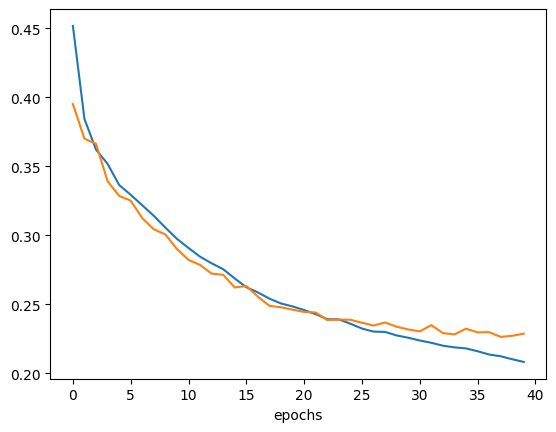

In [18]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.show()

## Predicting on test data

Generally after training your model, you can go right ahead and test it on the test data. For this problem, that won't work since our training set input and output data are not the same size as our test set's. Not only that but our data within our test set has varying size. Fortunately, RNNs deal with this problem rather easily. We can just specify the new size of the input and output data and load in the same weights. Previously, we split the test set up into a public (seq_len=107 and pred_len=107) and private (seq_len=130 and pred_len=130) test set so we'll be building models for both these sets

In [19]:
# build models
model_public = build_model(arch = 'gru', seq_len=107, pred_len=107)
model_private = build_model(arch = 'gru', seq_len=130, pred_len=130)

# load weights
model_public.load_weights('Model/cp-0038.h5')
model_private.load_weights('Model/cp-0038.h5')

### Make predictions

In [20]:
public_preds = model_public.predict(public_inputs)
private_preds = model_private.predict(private_inputs)

94/94 [==============================] - 4s 29ms/step


## Processing predictions

Now that we've made the predictions, we will have to process them into the form of the sample submission. Firstly, let's look at how the sample submission file is structured and the how the predicted data is structured

### Sample submission

In [34]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
sample_df 

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.0,0.0,0.0,0.0,0.0
457949,id_ffda94f24_126,0.0,0.0,0.0,0.0,0.0
457950,id_ffda94f24_127,0.0,0.0,0.0,0.0,0.0
457951,id_ffda94f24_128,0.0,0.0,0.0,0.0,0.0


### Prediction data

In [32]:
print(public_preds.shape)
print(private_preds.shape)

(629, 107, 5)
(3005, 130, 5)


The predictions data are grouping the prediction for each example in a 130x5 or 107x5 and the sample submission is denoting using id_seqpos to differentiate between examples and their bases. The final number in id_seqpos indicates the position at which the prediction falls in the sequence

### Processing predictions

Now we know what our prediction data looks like and how it's supposed to look like, we can now write code to process it

In the code below, the first for loop just loops between the private and public predictions/dataframes. The second for loop takes in an ID from the dataframe and all the predictions that were made for that ID. It generates an array of id_seqpos for the predictions and puts all these IDs and prediction into a singular dataframe. These dataframes are finally concatenated into a singular dataframe

In [22]:
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]
        single_df = pd.DataFrame(single_pred, columns=target_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        preds_ls.append(single_df)
    preds_df = pd.concat(preds_ls)

preds_df.head()

,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C,id_seqpos
0,0.642488,0.668479,0.634719,1.947166,0.879679,id_00073f8be_0
1,2.225926,3.393044,3.466540,4.482436,3.175923,id_00073f8be_1
2,1.510409,0.452585,0.609327,0.439830,0.648864,id_00073f8be_2
3,1.396393,1.170067,1.743364,1.217885,1.858102,id_00073f8be_3
4,0.924247,0.601397,0.853266,0.585345,0.926444,id_00073f8be_4


## Submission

We've got our data in the right format. Now we just need to merge our data with the sample sumbission. Luckily for us, pandas has a built in merge function

In [36]:
submission = sample_df[["id_seqpos"]].merge(preds_df, on=["id_seqpos"])
submission.to_csv("submission.csv", index=False)

submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_Mg_50C,deg_pH10,deg_50C
0,id_00073f8be_0,0.642488,0.668479,0.634719,1.947166,0.879679
1,id_00073f8be_1,2.225926,3.393044,3.466540,4.482436,3.175923
2,id_00073f8be_2,1.510409,0.452585,0.609327,0.439830,0.648864
3,id_00073f8be_3,1.396393,1.170067,1.743364,1.217885,1.858102
4,id_00073f8be_4,0.924247,0.601397,0.853266,0.585345,0.926444


## Conclusion

This was an interesting problem to put my knowledge on sequence models to the test. The data was also very different to what I have previously encountered. It was placed in a json file where multiple arrays for a single example. The training data and test data had different lengths. Luckily RNNs are extremely robust when it comes to dealing with inputs and outputs of varying length, so it was amazing to finally utilise this characteristic of RNNs